# **Proyek Akhir : Image Classification Model Deployment - Bottle Synthetic**
### Nama : Arif Budiman
### E-mail : arifbudiman2506@gmail.com
### ID Dicoding : arbud25

# **Pendahuluan**

Pertama-tama dalam proyek ini saya menggunakan dataset yang diperoleh dari [kaggle](https://www.kaggle.com/) yaitu data [Bottles Synthetic Images](https://www.kaggle.com/datasets/vencerlanz09/bottle-synthetic-images-dataset).

Data dari link kaggel tersebut akan dicopy API nya untuk diambil datanya berikut API dari Bottles Synthetic Images : (kaggle datasets download -d vencerlanz09/bottle-synthetic-images-dataset).

Berikut API Token yang diperoleh dari kaggle : [Kaggle API Token](https://drive.google.com/file/d/1OnxF8SKCfAsk5b2iBSU2v3NoIvWdwZjZ/view?pli=1).

Tujuan proyek ini adalah untuk membuat model kalsifikasi dari dataset botol yang nanti akan diklasifikasikan menjadi berbagai macam kategori, lalu model yang telah dibuat akan di convert dengan menggunakan TFLite



# **Import Library**

In [19]:
!pip install split-folders
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import splitfolders
import time
import pathlib
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# **Import Data Dari Kaggle Dengan API Command**

In [2]:
# Install kaggle API
!pip install kaggle

In [3]:
# Upload API Kaggle yang telah diperoleh
from google.colab import files

uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [4]:
# Set Up Directory Untuk Kaggle pada Google dan Download Datasetnya
import os

# Set up Kaggle directory
!mkdir ~/.kaggle

# Move the Kaggle API key to the correct location
!mv kaggle.json ~/.kaggle/

# Set permissions for the API key
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset using Kaggle API
!kaggle datasets download -d vencerlanz09/bottle-synthetic-images-dataset

# Unzip the downloaded dataset
!unzip -q bottle-synthetic-images-dataset.zip -d dataset

 99% 1.24G/1.26G [00:14<00:00, 158MB/s]
100% 1.26G/1.26G [00:14<00:00, 90.6MB/s]


In [5]:
# Cek isi pada direktori
os.listdir('/content/dataset/Bottle Images/Bottle Images')

['Soda Bottle',
 'Water Bottle',
 'Wine Bottle',
 'Plastic Bottles',
 'Beer Bottles']

In [6]:
# Cek jumlah datanya
def count_files_in_folder(folder_path):
    total_files = 0

    for root, dirs, files in os.walk(folder_path):
        total_files += len(files)

    return total_files

main_folder_path = '/content/dataset/Bottle Images/Bottle Images'

total_files_count = count_files_in_folder(main_folder_path)

print(f"Total jumlah data yang terdapat pada folder dan subfolders: {total_files_count}")

Total jumlah data yang terdapat pada folder dan subfolders: 25000


# **Train Test Split Data**

Untuk pembagian datanya adalah validation set 20% dari total dataset, pembagian data menggunakan library split-folders

In [7]:
# Buat Direktori Baru Untuk Ujicoba
# Tentukan path lengkap untuk direktori baru
new_directory = '/content/bottle_synthetic'

# Periksa apakah direktori sudah ada atau belum
if not os.path.exists(new_directory):
    # Jika belum, buat direktori baru
    os.makedirs(new_directory)
    print(f"Direktori {new_directory} berhasil dibuat.")
else:
    print(f"Direktori {new_directory} sudah ada.")

Direktori /content/bottle_synthetic berhasil dibuat.


In [8]:
# Gunakan split-folders untuk membagi dataset dan pindahkan ke folder yang baru dibuat dengan rasio train 80% dan val 20%
# Path sumber dataset
source_dir = '/content/dataset/Bottle Images/Bottle Images'

# Path direktori tujuan untuk data pelatihan dan validasi
output_dir = '/content/bottle_synthetic'

# Gunakan splitfolders untuk membagi dataset
splitfolders.ratio(source_dir, output=output_dir, seed=42, ratio=(0.8, 0.2))

print("Data berhasil dibagi antara data latih dan data validasi.")

Copying files: 25000 files [00:06, 3991.19 files/s]

Data berhasil dibagi antara data latih dan data validasi.


In [9]:
# Cek data latih pada folder baru
train_dir = '/content/bottle_synthetic/train'
os.listdir(train_dir)

['Soda Bottle',
 'Water Bottle',
 'Wine Bottle',
 'Plastic Bottles',
 'Beer Bottles']

In [10]:
# Cek data validasi pada folder baru
val_dir = '/content/bottle_synthetic/val'
os.listdir(val_dir)

['Soda Bottle',
 'Water Bottle',
 'Wine Bottle',
 'Plastic Bottles',
 'Beer Bottles']

# **Preprocessing Data**

In [11]:
# Menggunakan augmentasi gambar menggunakan ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    vertical_flip=True,
    fill_mode='nearest'
    )

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=128,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))

Found 20000 images belonging to 5 classes.


In [12]:
validation_datagen = ImageDataGenerator(
    rescale=1.0/255
)

validation_generator = validation_datagen.flow_from_directory(val_dir,
                                                              batch_size=32,
                                                              class_mode='categorical',
                                                              target_size=(150, 150))

Found 5000 images belonging to 5 classes.


# **Membuat Model**

In [13]:
# Buat arsitektur model dengan sequential
model_bottle = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64,(3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(128,(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(256,(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [14]:
# Melihat summary model
model_bottle.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 74, 74, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 128)       0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 36, 36, 128)       0

In [15]:
# Compile model yang sudah dibuat dengan learning_rate 1e-4 dan epochs 50
learning_rate = 1e-4
nomor_epochs = 50

optimizer = tf.optimizers.Adam(lr=learning_rate)
model_bottle.compile(optimizer=optimizer,
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

In [16]:
# Buat fungsi callback untuk mengetahui apabila akurasi dan val_akurasi sudah mencapai nilai yang diinginkan (92)
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.92 and logs.get('val_accuracy') > 0.92:
            print("\nAkurasi dan val_accuracy telah mencapai >92%!")
            self.model.stop_training = True

callbacks = MyCallback()

In [17]:
start = time.time()
history_bottle = model_bottle.fit(train_generator,
                                  epochs=nomor_epochs,
                                  steps_per_epoch=50,
                                  validation_data=validation_generator,
                                  batch_size=128,
                                  verbose=2,
                                  callbacks=[callbacks])
stop = time.time()
print(f"Lama Waktu Training yang Dibutuhkan: {round((stop - start)/60)}minute")

Epoch 1/50
50/50 - 76s - loss: 1.6440 - accuracy: 0.2770 - val_loss: 1.4120 - val_accuracy: 0.3584 - 76s/epoch - 2s/step
Epoch 2/50
50/50 - 64s - loss: 1.4022 - accuracy: 0.3655 - val_loss: 1.2970 - val_accuracy: 0.4200 - 64s/epoch - 1s/step
Epoch 3/50
50/50 - 72s - loss: 1.2951 - accuracy: 0.4221 - val_loss: 1.1952 - val_accuracy: 0.4772 - 72s/epoch - 1s/step
Epoch 4/50
50/50 - 63s - loss: 1.1718 - accuracy: 0.4998 - val_loss: 1.0035 - val_accuracy: 0.5690 - 63s/epoch - 1s/step
Epoch 5/50
50/50 - 64s - loss: 0.9635 - accuracy: 0.6091 - val_loss: 0.9692 - val_accuracy: 0.6136 - 64s/epoch - 1s/step
Epoch 6/50
50/50 - 72s - loss: 0.8181 - accuracy: 0.6740 - val_loss: 0.7707 - val_accuracy: 0.7196 - 72s/epoch - 1s/step
Epoch 7/50
50/50 - 64s - loss: 0.7130 - accuracy: 0.7287 - val_loss: 0.6058 - val_accuracy: 0.7790 - 64s/epoch - 1s/step
Epoch 8/50
50/50 - 65s - loss: 0.6335 - accuracy: 0.7614 - val_loss: 0.9142 - val_accuracy: 0.6954 - 65s/epoch - 1s/step
Epoch 9/50
50/50 - 63s - loss: 0

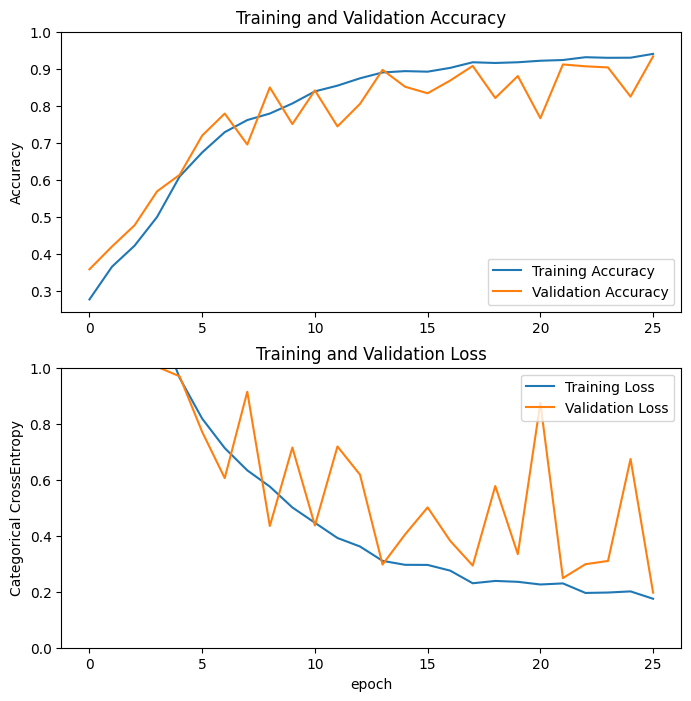

In [20]:
# Buat grafik untuk mengetahui akurasi dan loss
acc = history_bottle.history['accuracy']
val_acc = history_bottle.history['val_accuracy']

loss = history_bottle.history['loss']
val_loss = history_bottle.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Categorical CrossEntropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# **Convert Model**

Convert model yang telah dibuat dan diuji dengan Format TFLite

In [21]:
export_dir = 'saved_model/'
tf.saved_model.save(model_bottle, export_dir)

In [22]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

In [23]:
tflite_model_file = pathlib.Path('bottle.tflite')
tflite_model_file.write_bytes(tflite_model)

77382552